In [331]:
import pandas as pd
from scipy.stats import normaltest
import numpy as np
import re

import urllib.request

In [332]:
# utils
def clean_data(data):
    try:
        if type(data) == str:
            data.replace('*', '')
        return float(data)
    
    except ValueError:
        return float('nan')
    
    except TypeError:
        if data == None:
            float('nan')
        
latitude_pattern = r'lat.*?(-?\d+\.?\d*)'
longitude_pattern = r'lon.*?(-?\d+\.?\d*)'

def parse_top_metadata(url):

    location_string = ""

    for idx, line in enumerate(urllib.request.urlopen(url)):
        line = line.decode('utf-8')

        if 'yyyy' in line.lower():
            data_start_row = idx
            return location_string, data_start_row

        if re.search(longitude_pattern, line.lower()) or re.match(latitude_pattern, line.lower()):
            location_string += line


    
def extract_coords(location_string):

    lat_match = re.search(latitude_pattern, location_string)
    long_match = re.search(longitude_pattern, location_string)
    
    try:
        return (
            float(lat_match.group(1)), # even if multiple coords in the string, the first set of coordinates is acceptable for all use cases in this assignment
            float(long_match.group(1))
        )
    except AttributeError:
        print('could not extract coordinates from ' + location_string)
        return None
    

In [333]:
  
# load data 

headers = ['yyyy','mm','tmax', 'tmin','af','rain','sun']
df = pd.DataFrame(columns=headers, dtype='Float64')
converters = {header: clean_data for header in headers} # apply the same cleaning function to all columns

with open('./stations.txt', 'r') as f:
    stations = f.read().splitlines() #import stations into a list

for station in stations:

    url = f"http://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/{station}data.txt"

    location_string, data_start_row = parse_above_data(url)
    
    station_data = pd.read_csv(url,
                               sep=r'\s{2,}',
                               converters=converters,
                               na_values=['---'],
                               header=data_start_row,
                               skipinitialspace=True, 
                               engine='python',
                               on_bad_lines=lambda line: line[:len(headers)] #for lines longer than headers, truncate
                               )
        
    station_data = station_data.dropna(how='all') # remove rows with no data (only NaN values)

    coords = extract_coords(location_string.lower())
    station_data['latitude'] = coords[0]
    station_data['longitude'] = coords[1]
    
    station_data['station'] = station #add station name to all rows for this station

    df = pd.concat([df, station_data])

C:\Users\SeanGardner\AppData\Local\Temp\ipykernel_18532\786449685.py:34: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [334]:
def normalise_features(features):
    maxs = features.max()
    mins = features.min()
    normalised_features = (features - mins) / (maxs - mins)  
    return normalised_features


In [335]:
from sklearn.cluster import k_means

means_by_station = df.dropna(how='any').groupby(['station']).mean()

# normalise so each feature has unit variance
normalised_means = normalise_features(means_by_station)

centroid, label, inertia = k_means(normalised_means[['mm','tmax','tmin','af','rain','sun']],
                                   n_clusters=3,
                                   init='k-means++')

colours = ['red', 'blue', 'green']

clustered_means = means_by_station.assign(cluster=[colours[label] for label in label]) ## convert cluster names to ascii chars 


In [336]:
import plotly.express as px

fig = px.scatter_geo(clustered_means,
                     lat='latitude',
                     lon='longitude',
                     color='cluster',
                     hover_name=means_by_station.reset_index()['station']
                     )

fig.show()

In [337]:
# Investigate the third cluster

means_by_cluster = clustered_means.groupby('cluster').mean()

means_by_cluster

,yyyy,mm,tmax,tmin,af,rain,sun,latitude,longitude
cluster,,,,,,,,,
blue,1981.814232,6.494525,11.108149,4.936634,4.463135,131.706160,97.090790,56.064750,-3.407500
green,1981.080279,6.475660,13.803169,6.812670,2.877165,62.695898,133.859005,51.838938,-1.593313
red,1972.119121,6.483948,12.120663,5.306486,4.159491,70.080329,109.548638,55.330467,-3.417867


In [338]:
## Question B.2

uk_latitude_cutoffs = np.linspace(49.9, 60.9, 4)

third_labels = pd.cut(means_by_station['latitude'], 
                         bins=uk_latitude_cutoffs, 
                         labels=['Bottom', 'Middle', 'Top'], 
                         include_lowest=True)

test_features = normalised_means[-5:]
training_features = normalised_means[:-5]

test_labels = third_labels[-5:]
training_labels = third_labels[:-5]

In [339]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)

classifier.fit(training_features, training_labels)

predictions = classifier.predict(test_features)

In [340]:
#evaluate classification performance

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_labels, predictions)

print(f"{int(accuracy*100)}%")

predictions_series = pd.Series(predictions, index=test_labels.index, name="prediction")
test_labels_comparison = pd.concat([means_by_station[-5:], test_labels, predictions_series],
                                   axis=1,
                                   )

test_labels_comparison

80%


,yyyy,mm,tmax,tmin,af,rain,sun,latitude,longitude,latitude,prediction
station,,,,,,,,,,,
valley,1965.904706,6.495294,12.903765,7.374353,1.622353,70.843882,134.134235,53.252,-4.535,Bottom,Bottom
waddington,1977.668571,6.477143,13.059429,5.788857,3.864286,50.324286,127.784714,53.175,-0.522,Bottom,Bottom
whitby,2011.653846,6.419580,13.514685,6.700350,2.381119,58.254895,140.484266,54.481,-0.624,Middle,Bottom
wickairport,1969.148789,6.520761,10.509343,4.852249,3.854671,65.838235,104.285813,58.454,-3.088,Top,Top
yeovilton,1993.131915,6.485106,14.457872,6.120000,4.327660,59.970638,128.466383,51.006,-2.641,Bottom,Bottom


In [341]:
## Question B.3

import geopandas as gpd

region_gdf = gpd.read_file("boundaries_package.gpkg").to_crs('EPSG:4326').rename(columns={'nuts118nm':'region'})

#print(region_gdf['geometry'])

def add_region_to_df(df):

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs='EPSG:4326')

    #print(pd.concat([gdf['geometry'],region_gdf['geometry']], axis=1))
    
    return gdf.sjoin(region_gdf, how='inner', predicate='within')
    
means_with_region = add_region_to_df(means_by_station)

In [342]:
happiness_df = pd.read_csv('happiness_data.csv')

happiness_df = happiness_df.join(means_with_region.set_index('region'), on='region',
                  how='inner',
                  lsuffix='_left',
                  rsuffix='_right').reset_index()

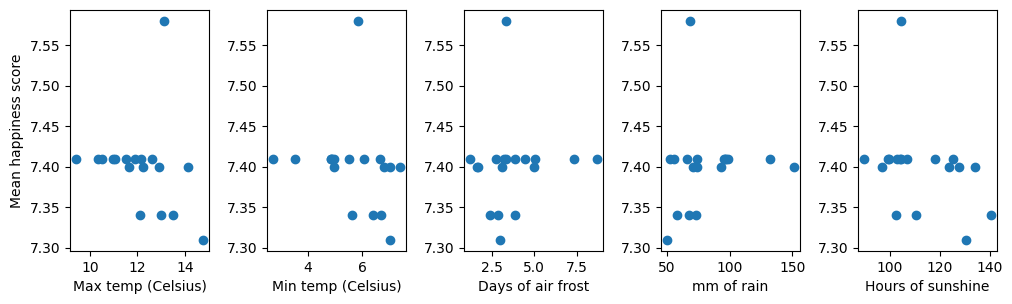

In [363]:
import matplotlib.pyplot as plt
import math

weather_features = {'tmax': 'Max temp (Celsius)', 'tmin': 'Min temp (Celsius)', 'af':'Days of air frost', 'rain':'mm of rain', 'sun': 'Hours of sunshine'}

fig, axs = plt.subplots(nrows=1, ncols=len(weather_features), figsize=(10,3))

fig.tight_layout()

axs[0].set_ylabel('Mean happiness score')

for idx, (feature, feature_label) in enumerate(weather_features.items()):
    axs[idx].scatter(happiness_df[feature], happiness_df['mean happiness score'])
    axs[idx].set_xlabel(feature_label) 
    


In [344]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

happiness_training_set = happiness_df[:-5]
happiness_test_set = happiness_df[-5:]

model.fit(happiness_training_set[weather_features.keys()],happiness_training_set['mean happiness score'])

happiness_predictions = model.predict(happiness_test_set[weather_features.keys()])

In [367]:
happiness_test_set['predictions'] = happiness_predictions

happiness_test_set['prediction_error'] = (happiness_test_set['predictions'] - happiness_test_set['mean happiness score'])

happiness_test_set[['predictions', 'mean happiness score', 'prediction_error']]

print(f"Median error of predicitons = {happiness_test_set['prediciton_error'].median()}")
print(f"Variance of training data = {happiness_training_set['mean happiness score'].var()}")

Median error of predicitons = 0.06597363899910746
Variance of training data = 2.3076923076922093e-05


C:\Users\SeanGardner\AppData\Local\Temp\ipykernel_18532\3682023510.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SeanGardner\AppData\Local\Temp\ipykernel_18532\3682023510.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

